##  Order of faces using ISOMAP


### First, I start off by visualizing the nearest neighbor graph with an adjacency matrix and test for a range of epilson.

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.sparse.linalg as ll
import sklearn.preprocessing as skpp
from sklearn.metrics import pairwise_distances
# from sklearn.metrics.pairwise import euclidean_distances
# distances = euclidean_distances(isomap,isomap)

In [11]:
isomap = spio.loadmat('data/isomap.mat',squeeze_me=True)['images']

In [12]:
isomap.shape

(4096, 698)

In [13]:
isomap = isomap.T

In [14]:
m, n = isomap.shape

In [15]:
def adj_matrix(X, eplison):
    # form a matrix of ecucliden distance between xi and xj
    distmat = pairwise_distances(X) 
    # within distance eplison
    distmat[distmat > eplison] = 0
#     A = (distmat <= eplison).astype(np.int64)
    return distmat

# Alternatively, from sklearn.neighbors.radius_neighbors_graph
# from sklearn.neighbors import radius_neighbors_graph
# A1 = radius_neighbors_graph(isomap, 15, mode='distance', include_self=True)

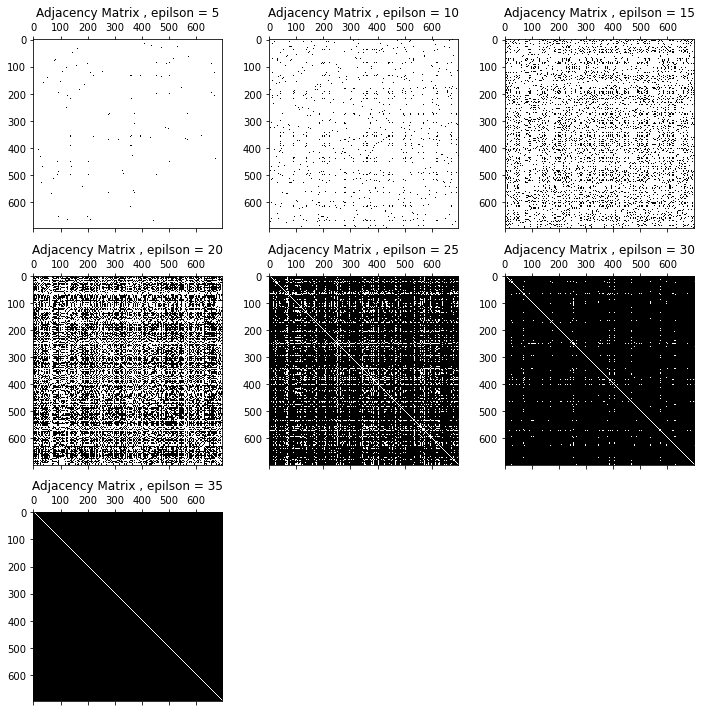

In [16]:
# Test for a range of epilson
%matplotlib inline

eplison_range = np.arange(5, 40, 5)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [10, 10]
for i, e in enumerate(eplison_range):
    A = adj_matrix(isomap, e)
    plt.subplot(3,3,i+1)
    plt.spy(A)
    plt.title('Adjacency Matrix , epilson = %d' % e)


plt.show()

### Based on the plots of Adjacency matrix of different epilson, it seems like a suitable epilson is between a range of 10 and 15. 

### Next, I can implement the ISOMAP algorithm to obtain a two-dimensional low-dimensional embedding. This involves coding the algorithm from scratch to ensure a thorough understanding of its mechanics and nuances. Once the embedding is computed, I aim to visualize it using a scatter plot,

### Subsequently, I will select several images and project them into the embedding space to observe their positioning relative to one another. By annotating the scatter plot with the locations of these images, I can assess any visual similarities among them and their arrangement within the embedding space. 

### With the use of epilson = 12, we can see that image with the same "face directions" are clustered together and plotted similar to the face direction E.g. images with face direction to the right are plotted at the right of the plot.

In [18]:
# MDS
# compute the shortest path from the distance matrix
A = adj_matrix(isomap, 12)
from scipy.sparse.csgraph import shortest_path
D = shortest_path(A, directed=False)
# centering matrix
H =  np.diag(np.ones(m)) - (1/m)*np.ones((m,m))    
G = -0.5 * H @ (D ** 2) @ H

In [19]:
# eigen-decomposition
lambd, v  = np.linalg.eig(G)
idx = np.argsort(lambd)
v = v[:, idx]

In [20]:
# get the top K eigen-vector and eigen-values
K = 2
v = v[:, -K:]
Z = v @ np.diag(np.sqrt(lambd[idx][-K:]))

In [21]:
select_pt = np.arange(0,648,60) #np.random.choice(m, 10)

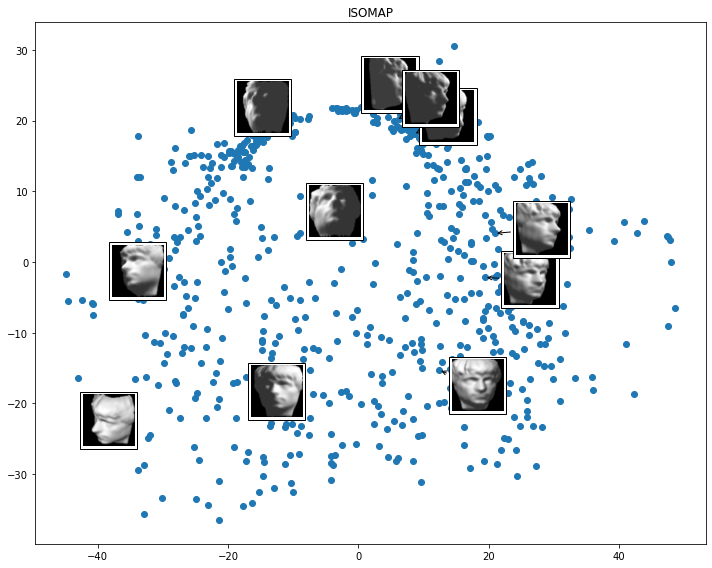

In [22]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

# visualize 
plt.rcParams["figure.figsize"] = [10.00, 8.0]
fig, ax = plt.subplots()
ax.scatter(Z[:,1], Z[:,0])
plt.title("ISOMAP")

for i in select_pt:
    xi = isomap[i]
    xi_reshape = np.reshape(xi, (64 , 64 ), order='C')
    xi_reshape = np.rot90(xi_reshape, axes=(1,0))
    im = OffsetImage(xi_reshape, zoom=0.8, cmap='gray')
    ab = AnnotationBbox(im, (Z[i,1], Z[i,0]),
    #                     xybox=(1.02, xy[1]),
                        xycoords='data',
                        boxcoords=("offset points"),
                        pad=0.3,
                        box_alignment=(0., 0.5),
                        arrowprops=dict(arrowstyle="->")
                       )
    ax.add_artist(ab)

plt.show()

### Next, I perform PCA on the images and project them into the top 2 principal components. I can see if there is a more meaningful projection using ISOMAP than PCA.

### In conclusion, we do not see a similar meaningful pattern as ISOMAP. For example, the image with face facing downwards left is found at the top right of the plot. 

In [23]:
m, n = isomap.shape

In [24]:
# taking reference from professor xia's PCA demo code 
x0 = isomap.T.reshape((n,m))
x = x0.astype(float)
m1 = x.shape[1]
Anew1 = x

In [25]:
# PCA
C1 = np.dot(Anew1,Anew1.T)/m1
K = 2
S1,W1 = ll.eigs(C1,k = K)
S1 = S1.real
W1 = W1.real

In [26]:
dim1_1 = np.dot(W1[:,0].T,Anew1)/math.sqrt(S1[0])
dim2_1 = np.dot(W1[:,1].T,Anew1)/math.sqrt(S1[1])

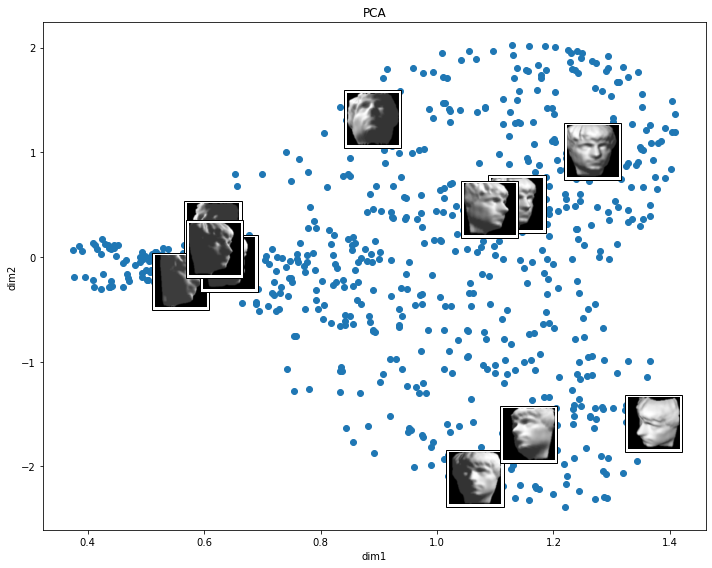

In [27]:
# plt.figure(figsize=(10, 10), dpi=80)
# plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plt.rcParams["figure.figsize"] = [10.00, 8.0]
fig, ax = plt.subplots()
ax.scatter(dim1_1, dim2_1)
plt.title("PCA")
plt.xlabel('dim1')
plt.ylabel('dim2')

for i in select_pt:
    xi = isomap[i]
    xi_reshape = np.reshape(xi, (64 , 64 ), order='C')
    xi_reshape = np.rot90(xi_reshape, axes=(1,0))
    im = OffsetImage(xi_reshape, zoom=0.8, cmap='gray')
    ab = AnnotationBbox(im, (dim1_1[i], dim2_1[i]),
    #                     xybox=(1.02, xy[1]),
                        xycoords='data',
                        boxcoords=("offset points"),
                        pad=0.3,
                        box_alignment=(0., 0.5),
                        arrowprops=dict(arrowstyle="->")
                       )
    ax.add_artist(ab)

plt.show()
